<a href="https://colab.research.google.com/github/jisoolee11/study/blob/main/Dacon/keypoint(test1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> 모션 키포인트 검출 AI 경진대회

In [1]:
! pip install albumentations

     |████████████████████████████████| 634kB 8.5MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=21f0e05158558773fc612cbed3538651c176d34611fe17b20a402e990f5030c6
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [2]:
!pip install --upgrade albumentations

     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 952kB 15.1MB/s 
     |████████████████████████████████| 37.6MB 128kB/s 
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import os
from typing import Tuple, List, Sequence, Callable, Dict

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN
from torchsummary import summary
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data/keypoint/train_df.csv')
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.000000,368.000000,1134.0,371.0,1003.497242,327.640085,1078.000000,341.00000,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.000000,398.000000,1144.0,337.0,1004.000000,346.000000,1094.000000,326.00000,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,334.109461,1020.0,381.0,1083.0,389.0,984.000000,362.000000,1163.0,372.0,1027.507419,327.383120,1111.000000,340.00000,1016.0,552.0,1061.0,556.0,1018.0,674.0,1070.0,696.0,987.703151,788.867342,1044.0,826.0,1063.029716,358.679953,1042.374777,319.031541,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,359.351579,968.0,392.0,1010.0,411.0,941.812612,339.703151,1109.0,441.0,971.654931,328.648429,1066.812604,383.40631,972.0,571.0,1000.0,559.0,991.0,700.0,1110.0,469.0,991.406302,816.132650,1133.0,591.0,1007.302983,374.179405,981.842327,329.109461,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,338.187380,997.0,393.0,1054.0,395.0,961.000000,423.000000,1132.0,360.0,988.676303,357.688297,1080.000000,337.00000,1000.0,567.0,1043.0,570.0,1017.0,673.0,1059.0,701.0,998.406302,784.570501,1040.0,827.0,1036.318945,366.195727,999.777421,349.829291,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


In [5]:
def draw_keypoints(image: np.ndarray, keypoints: np.ndarray, edges: List[Tuple[int, int]]) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}
    x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
    x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        cv2.putText(
            image, 
            f'{i}: {keypoint_names[i]}', 
            tuple(keypoint), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    for i, edge in enumerate(edges):
        cv2.line(
            image, 
            tuple(keypoints[edge[0]]), 
            tuple(keypoints[edge[1]]),
            colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=200)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')

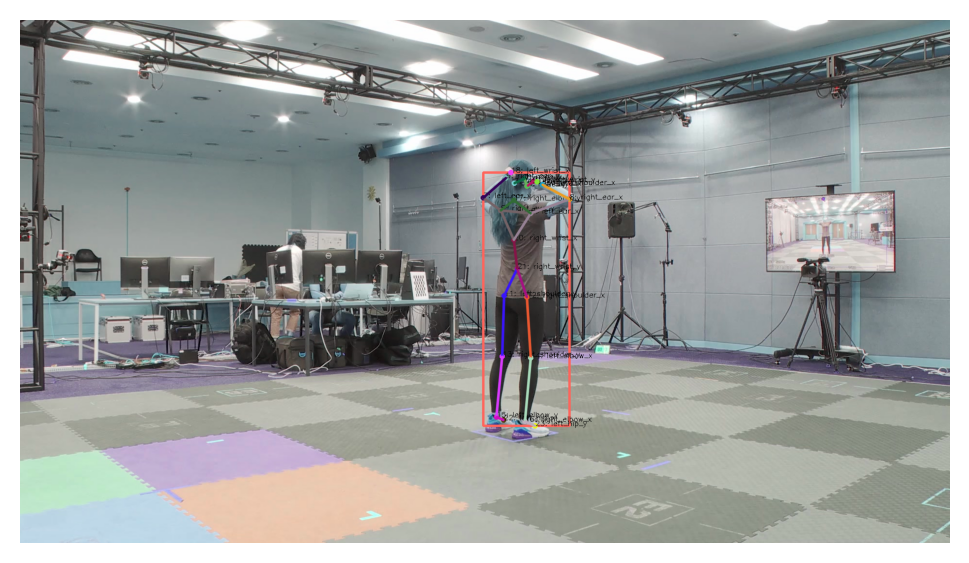

In [6]:
keypoints = df.iloc[0, 1:].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = df.columns[1:].tolist()

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (11, 13), (13, 15), (12, 14), 
    (14, 16), (5, 6), (15, 22), (16, 23), (11, 21),
    (21, 12), (20, 21), (5, 20), (6, 20), (17, 6), (17, 5)
]

image = cv2.imread('/content/drive/MyDrive/Data/keypoint/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
draw_keypoints(image, keypoints, edges)

In [7]:
# torchvision 모형을 이용한 추론
image = cv2.imread('/content/drive/MyDrive/Data/keypoint/train_imgs/001-1-1-01-Z17_A-0000001.jpg',cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1333, 800))
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = keypointrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()
preds = model(image)
preds[0].keys()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

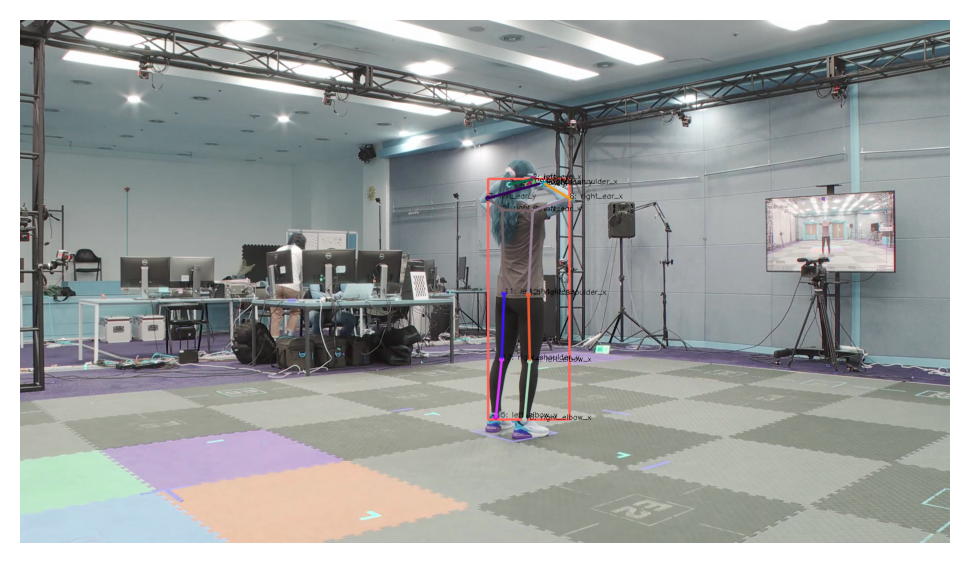

In [8]:
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('/content/drive/MyDrive/Data/keypoint/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
keypoints[:, 0] *= image.shape[1]/1333
keypoints[:, 1] *= image.shape[0]/800
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)       
]

draw_keypoints(image, keypoints, edges)

In [9]:
# Keypoint R-CNN 학습하기
class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_path: os.PathLike,
        transforms: Sequence[Callable]=None
    ) -> None:
        self.image_dir = image_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms
    
    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index: int) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)

        targets = {
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets['image']
        image = image / 255.0

        targets = {
            'labels':torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes':torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints':torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24,1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

In [10]:
transforms = A.Compose([
    A.Resize(800, 1333),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor()
],  bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels']),
    keypoint_params = A.KeypointParams(format='xy')     
)

In [11]:
# transforms_train = transforms.Compose([
#     transforms.Resize((1333, 800)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         [0.485, 0.456, 0.406],
#         [0.229, 0.224, 0.225]
#     )
# ])

In [12]:
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))


trainset = KeypointDataset('/content/drive/MyDrive/Data/keypoint/train_imgs', '/content/drive/MyDrive/Data/keypoint/train_df.csv', transforms)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0) # collate_fn=collate_fn

In [13]:
def get_model() -> nn.Module:
    backbone = mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone,
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [14]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model().to(device)

    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for i, (images, targets) in enumerate(train_loader):
           
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            losses = model(images, targets)

            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print(f'|epoch:{epoch}|loss:{loss.item():.4f}', end='|')
                for k, v in losses.items():
                    print(f'{k[5:]}:{v.item():.4f}', end='|')
                print()

In [15]:
# train()

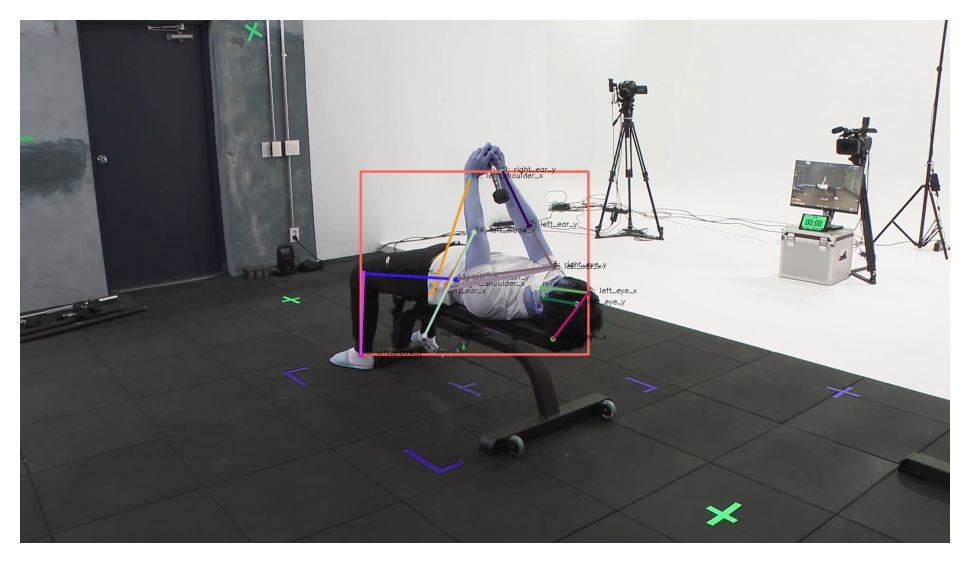

In [16]:
# 학습한 모형에서 추론
image = cv2.imread('/content/drive/MyDrive/Data/keypoint/test_imgs/649-2-4-32-Z148_A-0000001.jpg', cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1333, 800))
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]


model.eval()
preds = model(image)
preds[0].keys()
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('/content/drive/MyDrive/Data/keypoint/test_imgs/649-2-4-32-Z148_A-0000001.jpg', cv2.COLOR_BGR2RGB)
keypoints[:, 0] *= image.shape[1]/1333
keypoints[:, 1] *= image.shape[0]/800
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]

draw_keypoints(image, keypoints, edges)